# Topic 1A 
**What time and space like interactions are most significant in multivariate systems?**

Setup
1.	Generate a 3D dataframe of times, variables, and their values, for a given timeseries of the first category of specifically discretised interactions.
2.	Write code to compute a list of cliques and their mutual information for a given 3D dataframe. The dataframe should contain the desired variables and their values over time. (for 3 variables, the output list should have length 14)
3.	Store the mutual informations as 2D matrix in a list, so a 3D dataframe.
4.	Plot <MI> vs dt, what result?

___________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Import libraries

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import infotopo
from sklearn.utils import Bunch

Import test data

In [24]:
df = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\timeseries_test.txt", sep='\t', header=0, usecols=lambda col: col != 'Time')  # choose between timeseries_test.txt and timeseries_test2.txt

Plot the timeseries for visualization

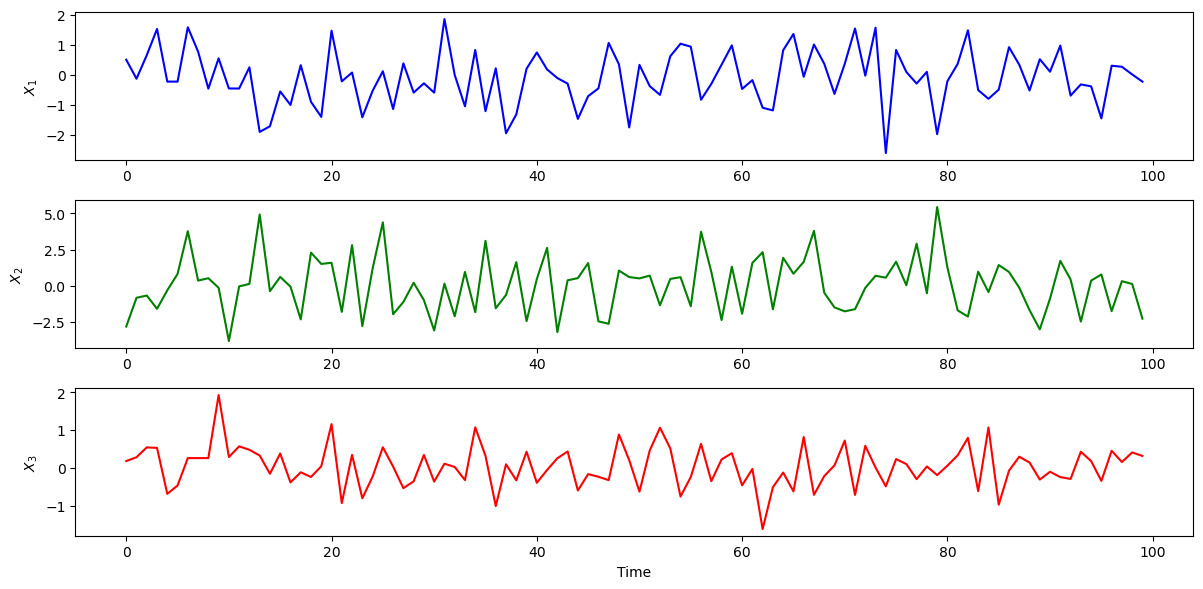

In [23]:
# Convert columns 1, 2, and 3 into lists of values
x_t = df.iloc[:, 0].tolist()
y_t = df.iloc[:, 1].tolist()
z_t = df.iloc[:, 2].tolist()
time = np.arange(0, len(x_t))

# Create the figure and subplots
plt.figure(figsize=(12, 6))  # Adjust the figure size to fit 3 plots

# First subplot for Series 1
plt.subplot(3, 1, 1)  # (3 rows, 1 column, first subplot)
plt.plot(time, x_t, label='Series 1', color='blue')
#plt.xlabel('Time')
plt.ylabel('$X_{1}$')
#plt.title('Series 1')
#plt.legend()

# Second subplot for Series 2
plt.subplot(3, 1, 2)  # (3 rows, 1 column, second subplot)
plt.plot(time, y_t, label='Series 2', color='green')
#plt.xlabel('Time')
plt.ylabel('$X_{2}$')
#plt.title('Series 2')
#plt.legend()

# Third subplot for Series 3
plt.subplot(3, 1, 3)  # (3 rows, 1 column, third subplot)
plt.plot(time, z_t, label='Series 3', color='red')
plt.xlabel('Time')
plt.ylabel('$X_{3}$')
#plt.title('Series 3')
#plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Choose from which time and space like separations to compute the metrics

In [34]:
def time_slice(data, x_start, y_start, z_start, window_size):

    data_slice = pd.DataFrame({
        "Variable1": data["Variable1"].iloc[x_start:x_start+window_size].reset_index(drop=True),
        "Variable2": data["Variable2"].iloc[y_start:y_start+window_size].reset_index(drop=True),
        "Variable3": data["Variable3"].iloc[z_start:z_start+window_size].reset_index(drop=True)
    })

    return data_slice

In [35]:
time_slice_data = time_slice(df, 0, 0, 10, 10)

Divide into timewindows and generate dataframe

In [6]:
step_size = 10 # Step size (timesteps per slice)

# Ensure the number of rows is divisible by the step size
num_rows = df.shape[0]
if num_rows % step_size != 0:
    raise ValueError("Number of rows in the DataFrame must be divisible by the step size.")

# Reshape into 3D array
reshaped_df = df.values.reshape(-1, step_size, df.shape[1])

# Convert the 3D array back to a DataFrame-like structure if needed
df_discretized = []
for i in range(reshaped_df.shape[0]):
    df_discretized.append(pd.DataFrame(reshaped_df[i], columns=df.columns))

Discretize the timeseries

In [7]:
time_window = 5

# Mask using the 99th and 1th percentile
df = df_discretized[time_window]
stacked_series = df.stack()
quantile_99 = stacked_series.quantile(0.99)
quantile_01 = stacked_series.quantile(0.01)
df[df > quantile_99] = quantile_99
df[df < quantile_01] = quantile_01

# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()
max_BOLD = df.max().max()
min_BOLD = df.min().min()
desired_number_of_bins = 16
stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [10]:
# Convert DataFrame to Bunch
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    # Create Bunch object
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Example usage
bunch = dataframe_to_bunch(discretized_time_series)

In [16]:
def obtain_infotopo_metrics(dataset):
    
    dimension_max = dataset.shape[1]
    dimension_tot = dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = False
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(bunch.data) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

Percent of tuples processed : 0


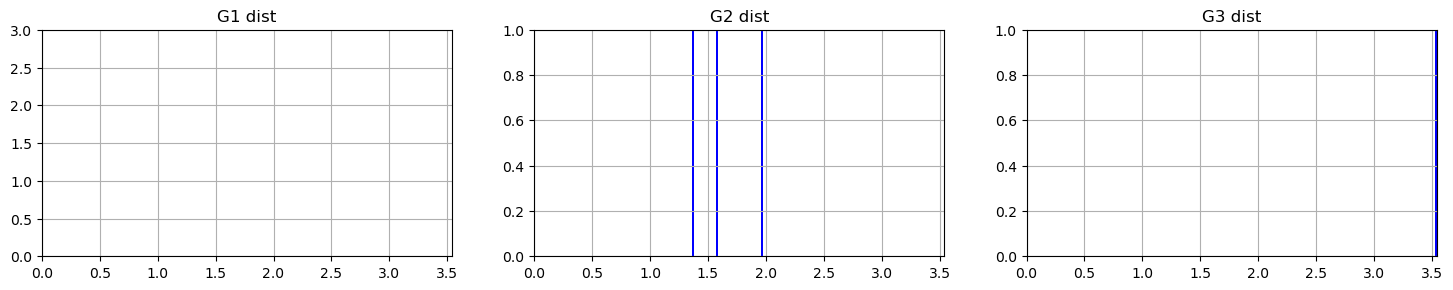

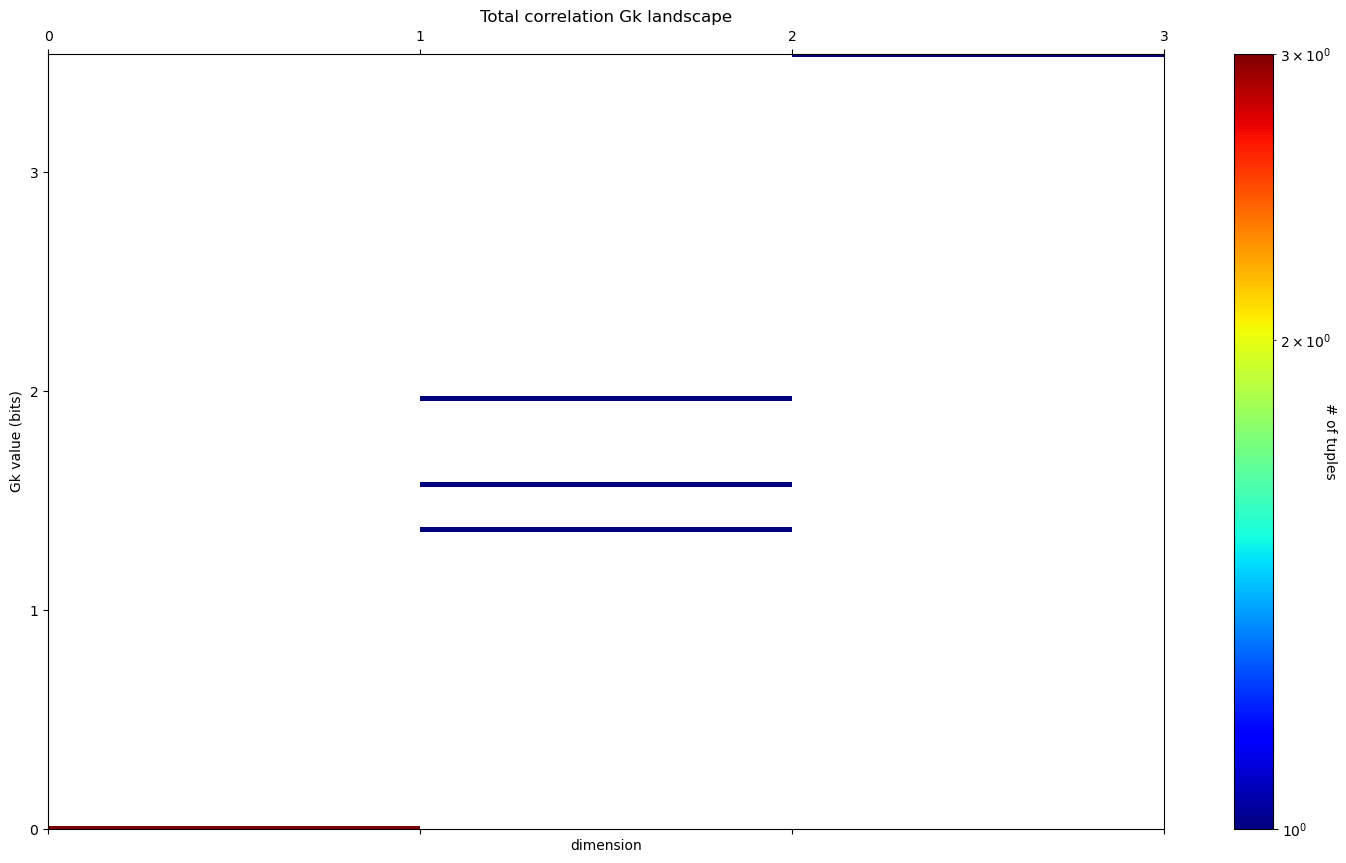

In [17]:
Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch.data)

In [18]:
Nentropie

{(3,): 2.6464393446710153,
 (2,): 2.6464393446710153,
 (1,): 1.570950594454669,
 (2, 3): 3.321928094887362,
 (1, 3): 2.8464393446710154,
 (1, 2): 2.6464393446710153,
 (1, 2, 3): 3.321928094887362}

In [19]:
Ninfomut

{(3,): 2.6464393446710153,
 (2,): 2.6464393446710153,
 (1,): 1.570950594454669,
 (2, 3): 1.9709505944546684,
 (1, 3): 1.3709505944546692,
 (1, 2): 1.5709505944546693,
 (1, 2, 3): 1.3709505944546692}

In [20]:
average_free_energy = sum(Nfree_energy.values())/len(Nfree_energy.values())
print(average_free_energy)

average_free_energy_component = sum(Ninfomut.values())/len(Ninfomut.values())
print(average_free_energy_component)

1.2078218531819063
1.878233094516482
